# Make the figures for the paper

This notebook generates the figures used in the paper. **No results are calculated here**. We'll only load the results from files produced by other notebook.

## Package imports

In [1]:
# Insert the plots into the notebook
%matplotlib inline

In [2]:
from __future__ import division
import cPickle as pickle
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import seaborn  # Makes the default style of the plots nicer

In [3]:
from datasets import fetch_crust1, load_icgem_gdf, down_sample
from mohoinv import predict_seismic

Set the global plot style parameters.

In [4]:
seaborn.set_context('paper')
config = dict(fontsize=7)
plt.rcParams['font.size'] = config['fontsize']
plt.rcParams['axes.labelsize'] = config['fontsize']
plt.rcParams['xtick.labelsize'] = config['fontsize']
plt.rcParams['ytick.labelsize'] = config['fontsize']
plt.rcParams['legend.fontsize'] = config['fontsize']
plt.rcParams['xtick.major.pad'] = 3
plt.rcParams['ytick.major.pad'] = 3

The function below takes the data and sets the colorbar limits so that zero falls in the middle of the color range.

In [5]:
def data_minmax(data, shift=0):
    ranges = np.abs([data.min(), data.max()]).max()
    return dict(vmin=-ranges + shift, vmax=ranges + shift)

## Simple synthetic

This section generates figures for the simple synthetic data application.

Load the model, synthetic data, and the results dictionary.

In [6]:
with open('../model/synthetic-simple.pickle') as f:
    model = pickle.load(f)

In [7]:
with open('../data/synthetic-data-simple.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    lat, lon, height, data = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 4])

In [8]:
with zipfile.ZipFile('results/synthetic-simple-newton.zip') as f:
    results = pickle.load(f.open('synthetic-simple-newton.pickle'))

In [9]:
results.keys()

['best_index',
 'solution',
 'solutions',
 'scores',
 'regul_params',
 'config',
 'metadata']

In [10]:
print(results['metadata'])

Generated by sinthetic-simple.ipynb on 07 February 2016 00:10:15 UTC


Make the map projection for these plots.

In [11]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='c')

Plot the data and model in a figure.

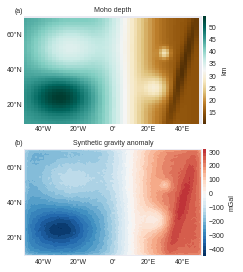

In [12]:
fig = plt.figure(figsize=(3.33, 3.7))

grid = AxesGrid(fig, [0.08, 0.05, 0.8, 0.9], 
                nrows_ncols=(2, 1), axes_pad=0.35,
                cbar_location="right", cbar_mode="each",
                cbar_size="2%", cbar_pad=0.01)

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(-0.05, 1.04, '(a)', transform=ax.transAxes, **config)
ax.set_title('Moho depth', **config)
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))
tmp = bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='BrBG')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=10))
cbax.set_ylabel('km')
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(-0.05, 1.04, '(b)', transform=ax.transAxes, **config)
ax.set_title('Synthetic gravity anomaly', **config)
x, y = bm(lon.reshape(shape), lat.reshape(shape))
tmp = bm.contourf(x, y, data.reshape(shape), 30, cmap='RdBu_r', **data_minmax(data))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
cbax.set_ylabel('mGal')
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

plt.savefig('../manuscript/figures/synthetic-simple-data.eps')

Extract some of the data from the results dictionary.

In [13]:
moho = results['solution'].estimate_    
solution = results['solution'][0]
residuals = solution.residuals()
regul_params = results['regul_params']
scores = results['scores']
best = results['best_index']
solver = results['solution']
diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)

Make a figure of the inversion results.

/home/leo/bin/anaconda/envs/moho/lib/python2.7/site-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


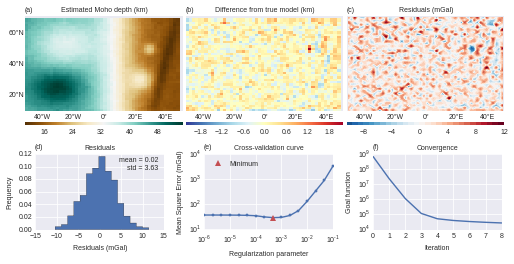

In [14]:
fig = plt.figure(figsize=(7, 3.5))

# The first part will be 3 maps
grid = AxesGrid(fig, [0.04, 0.33, 0.95, 0.8], 
                nrows_ncols=(1, 3), axes_pad=0.05,
                cbar_location="bottom", cbar_mode="each",
                cbar_size=0.04, cbar_pad=0.15)

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(a)', transform=ax.transAxes, **config)
ax.set_title('Estimated Moho depth (km)', **config)
x, y = bm(moho.lons, moho.lats)
tmp = bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='BrBG')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels([20, 40, 60], labels=[1, 0, 0, 0], linewidth=0, **config)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(b)', transform=ax.transAxes, **config)
ax.set_title('Difference from true model (km)', **config)
tmp = bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', **data_minmax(diff))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.05, '(c)', transform=ax.transAxes, **config)
ax.set_title('Residuals (mGal)', **config)
x, y = bm(solution.lon, solution.lat)
tmp = bm.contourf(x, y, residuals, 30, tri=True, cmap='RdBu_r', **data_minmax(residuals))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-40, -20, 0, 20, 40], labels=[0, 0, 0, 1], linewidth=0, **config)

# Now make the axes to plot the 3 graphs on the bottom
height, bottom = 0.3, 0.1
left,  width, pad = 0.06, 0.255, 0.08
grid2 = [plt.axes([left, bottom, width, height]),
         plt.axes([left + width + pad, bottom, width, height]),
         plt.axes([left + 2*(width + pad), bottom, width, height])]

ax = grid2[0]
ax.text(0, 1.07, '(d)', transform=ax.transAxes, **config)
ax.set_title('Residuals', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    residuals.mean(), residuals.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(residuals, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Residuals (mGal)')
ax.set_ylabel('Frequency')

ax = grid2[1]
ax.text(0, 1.07, '(e)', transform=ax.transAxes, **config)
ax.set_title('Cross-validation curve', **config)
ax.plot(regul_params, scores, '.-')
ax.plot(regul_params[best], scores[best], '^', 
         color=seaborn.color_palette()[2], 
         label='Minimum')
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Regularization parameter')
ax.set_ylabel(u'Mean Square Error (mGal)')

ax = grid2[2]
ax.text(0, 1.07, '(f)', transform=ax.transAxes, **config)
ax.set_title("Convergence", **config)
ax.plot(range(solver.stats_['iterations'] + 1), solver.stats_['objective'])
ax.set_yscale('log')
ax.set_xlabel('Iteration')
ax.set_ylabel('Goal function')

plt.savefig('../manuscript/figures/synthetic-simple-results.eps')

## CRUST1.0 synthetic

In [15]:
with open('../model/synthetic-crust1.pickle') as f:
    model = pickle.load(f)

In [16]:
with open('../data/synthetic-data-crust1.txt') as f:
    for i in range(2):
        f.readline()
    line = f.readline()
    shape = map(int, line.split()[1:])
    lat, lon, height, data = np.loadtxt(f, unpack=True, usecols=[0, 1, 2, 4])

In [17]:
latp, lonp, depthp = np.loadtxt('../data/crust1-point-depths.txt', unpack=True)

In [18]:
with zipfile.ZipFile('results/synthetic-crust1.zip') as f:
    results = pickle.load(f.open('synthetic-crust1.pickle'))

In [19]:
results.keys()

['models_refdens',
 'densities',
 'reference_levels',
 'solution_regul',
 'scores_regul',
 'models_regul',
 'solution',
 'best_dens',
 'scores_refdens',
 'best_regul',
 'regul_params',
 'config',
 'best_ref',
 'metadata']

In [20]:
print(results['metadata'])

Generated by sinthetic-crust1.ipynb on 05 February 2016 21:48:27 UTC


Make the map projection for these plots.

In [21]:
bm = Basemap(projection='cyl', 
             llcrnrlon=model.area[2], urcrnrlon=model.area[3], 
             llcrnrlat=model.area[0], urcrnrlat=model.area[1],
             resolution='c')

Plot the data and model in a figure.

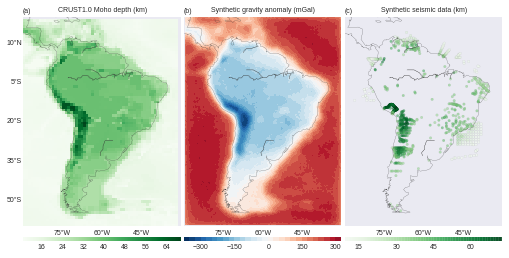

In [22]:
fig = plt.figure(figsize=(7, 3.5))

grid = AxesGrid(fig, [0.04, 0.01, 0.95, 0.98], 
                nrows_ncols=(1, 3), axes_pad=0.05,
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('CRUST1.0 Moho depth (km)', **config)
ax.text(0, 1.02, '(a)', transform=ax.transAxes, **config)
x, y = bm(model.lon.reshape(model.shape), model.lat.reshape(model.shape))
tmp = bm.pcolormesh(x, y, -0.001*model.relief.reshape(model.shape), cmap='Greens')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=8))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('Synthetic gravity anomaly (mGal)', **config)
ax.text(0, 1.02, '(b)', transform=ax.transAxes, **config)
x, y = bm(lon.reshape(shape), lat.reshape(shape))
tmp = bm.contourf(x, y, data.reshape(shape), 30, cmap='RdBu_r', **data_minmax(data))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.set_title('Synthetic seismic data (km)', **config)
ax.text(0, 1.02, '(c)', transform=ax.transAxes, **config)
xp, yp = bm(lonp, latp)
tmp = bm.scatter(xp, yp, c=depthp*0.001, s=7, cmap='Greens', alpha=0.6,
                 linewidths=0.05)
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

plt.savefig('../manuscript/figures/synthetic-crust1-data.eps')

Extract some things from the results dictionary.

In [23]:
moho = results['solution'].estimate_    
solution = results['solution'][0]
residuals = solution.residuals()
regul_params = results['regul_params']
scores_regul = results['scores_regul']
best_reg = results['best_regul']
reference_levels = results['reference_levels']
densities = results['densities']
scores_refdens = results['scores_refdens']
best_ref = results['best_ref']
best_dens = results['best_dens']
diff_seismic = -0.001*(-depthp - predict_seismic(moho, latp, lonp))

Make a figure of the inversion results.

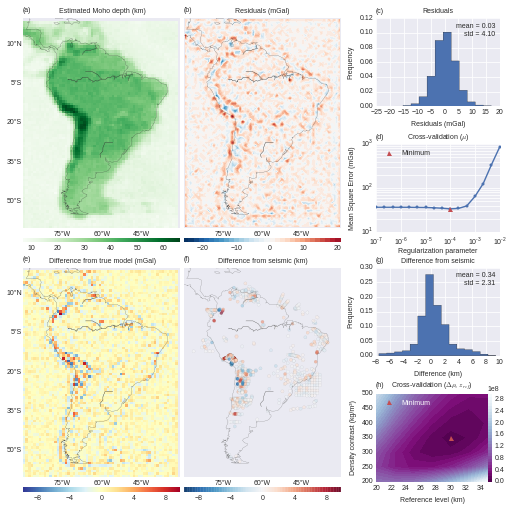

In [27]:
fig = plt.figure(figsize=(7, 7))

# The first part will be 4 maps
grid = AxesGrid(fig, [0.04, 0.01, 0.63, 0.98], 
                nrows_ncols=(2, 2), axes_pad=(0.05, 0.35),
                cbar_location="bottom", cbar_mode="each",
                cbar_size="2%", cbar_pad="5%")

i = 0
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(a)', transform=ax.transAxes, **config)
ax.set_title('Estimated Moho depth (km)', **config)
x, y = bm(moho.lons, moho.lats)
tmp = bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 1
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(b)', transform=ax.transAxes, **config)
ax.set_title('Residuals (mGal)', **config)
x, y = bm(solution.lon, solution.lat)
tmp = bm.contourf(x, y, residuals, 30, tri=True, cmap='RdBu_r', **data_minmax(residuals))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 2
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(e)', transform=ax.transAxes, **config)
ax.set_title('Difference from true model (mGal)', **config)
x, y = bm(moho.lons, moho.lats)
diff = -0.001*(model.relief - moho.relief).reshape(moho.shape)
tmp = bm.pcolormesh(x, y, diff, cmap='RdYlBu_r', **data_minmax(diff))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0, **config)
bm.drawcoastlines(color="#333333", linewidth=0.2)

i = 3
ax, bm.ax, cbax = grid[i], grid[i], grid.cbar_axes[i]
ax.text(0, 1.03, '(f)', transform=ax.transAxes, **config)
ax.set_title('Difference from seismic (km)', **config)
xp, yp = bm(lonp, latp)
tmp = bm.scatter(xp, yp, c=diff_seismic, s=10, cmap='RdBu_r', alpha=0.6,
                 linewidths=0.05, **data_minmax(diff))
cb = cbax.colorbar(tmp, locator=ticker.MaxNLocator(nbins=6))
bm.drawmeridians([-75, -60, -45], labels=[0, 0, 0, 1], linewidth=0, **config)
bm.drawcoastlines(color="#666666", linewidth=0.2)

# Now make the axes to plot the 4 graphs on the right
height, pad = 0.25, 0.075
left, width = 0.74, 0.245
grid2 = [plt.axes([left, 0.545 + height, width, height - pad]),
         plt.axes([left, 0.545, width, height - pad]),
         plt.axes([left, 0.05 + height, width, height - pad]),
         plt.axes([left, 0.05, width - 0.015, height - pad])]

ax = grid2[0]
ax.text(0, 1.06, '(c)', transform=ax.transAxes, **config)
ax.set_aspect('auto')
ax.set_title('Residuals', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    residuals.mean(), residuals.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(residuals, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Residuals (mGal)')
ax.set_ylabel('Frequency')

ax = grid2[1]
ax.text(0, 1.06, '(d)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\mu$)', **config)
ax.plot(regul_params, scores_regul, marker='o', markersize=3)
ax.plot(regul_params[best_reg], scores_regul[best_reg], '^', markersize=5, 
        color=seaborn.color_palette()[2], 
        label='Minimum')
ax.legend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Regularization parameter', labelpad=0.5)
ax.set_ylabel(u'Mean Square Error (mGal)')
ax.yaxis.grid(True, which='minor')

ax = grid2[2]
ax.text(0, 1.06, '(g)', transform=ax.transAxes, **config)
ax.set_title('Difference from seismic', **config)
text = "mean = {:.2f}\n    std = {:.2f}".format(
    diff_seismic.mean(), diff_seismic.std())
ax.text(0.65, 0.8, text, transform=ax.transAxes, **config)
ax.hist(diff_seismic, bins=15, normed=True, histtype='stepfilled')
ax.set_xlabel('Difference (km)')
ax.set_ylabel('Frequency')

ax = grid2[3]
ax.text(0, 1.07, '(h)', transform=ax.transAxes, **config)
ax.set_title(r'Cross-validation ($\Delta\rho$, $z_{ref}$)', **config)
tmp = ax.contourf(-0.001*reference_levels, densities, scores_refdens, 30, cmap='BuPu_r')
divider = make_axes_locatable(ax)
cbax = divider.append_axes("right", size=0.05, pad=0.01)
plt.colorbar(tmp, cax=cbax)
ax.plot(-0.001*reference_levels[best_ref], densities[best_dens], '^', markersize=5, 
        color=seaborn.color_palette()[2], label='Minimum')
l = ax.legend(loc='upper left')
for txt in l.get_texts():
    txt.set_color('#ffffff')
ax.set_xlabel('Reference level (km)')
ax.set_ylabel(u'Density contrast (kg/m³)')

plt.savefig('../manuscript/figures/synthetic-crust1-results.eps')

## Gravity data for South America

In [13]:
seaborn.set_context('paper')
fig_file = '../manuscript/figures/sam-gravity-{}.eps'
fig_args = dict(facecolor='none')

In [5]:
with open('../data/processed-goco5s-data-sam-h50km.txt') as f:
    f.readline()
    shape = tuple(int(i) for i in f.readline().split()[1:])
    data = np.loadtxt(f, unpack=True)
    lat, lon, height, topo, grav, disturbance, topo_effect, bouguer = data[:8]
    upper_sed, middle_set, lower_sed, total_sed, sedfree_bouguer = data[8:]
    area = (lat.min(), lat.max(), lon.min(), lon.max())

Setup a [basemap](http://matplotlib.org/basemap/index.html) to plot the data with an appropriate projection.

In [6]:
bm = Basemap(projection='cyl', 
             llcrnrlon=area[2], urcrnrlon=area[3], llcrnrlat=area[0], urcrnrlat=area[1],
             lon_0=0.5*(area[2] + area[3]), lat_0=0.5*(area[1] + area[0]), 
             resolution='l')

In [7]:
x, y = bm(lon, lat) # Transform lat and lon into plot coordinates

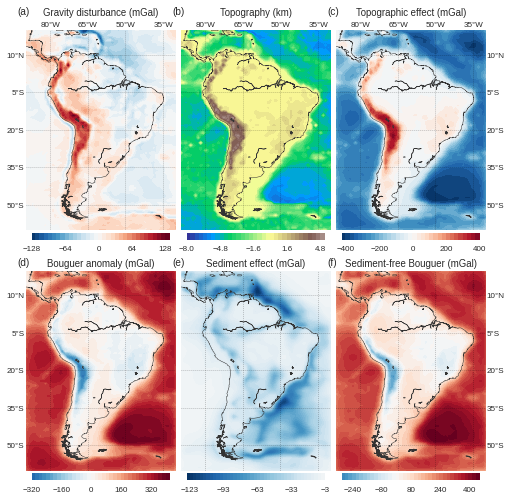

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(7, 7))
axes = axes.ravel()

cbargs = dict(orientation='horizontal', pad=0.01, aspect=20, shrink=0.9)
gridargs = dict(linewidth=0.2, fontsize=8)

ax = axes[0]
ax.text(-0.05, 1.08, '(a)', transform=ax.transAxes)
ax.set_title('Gravity disturbance (mGal)', y=1.05)
ranges = np.abs([disturbance.min(), disturbance.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), disturbance.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='RdBu_r', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('mGal')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 1, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

ax = axes[1]
ax.text(-0.05, 1.08, '(b)', transform=ax.transAxes)
ax.set_title('Topography (km)', y=1.05)
ranges = np.abs([0.001*topo.min(), 0.001*topo.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), 0.001*topo.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='terrain', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('km')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 1, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 0, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

ax = axes[2]
ax.text(-0.05, 1.08, '(c)', transform=ax.transAxes)
ax.set_title('Topographic effect (mGal)', y=1.05)
ranges = np.abs([topo_effect.min(), topo_effect.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), topo_effect.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='RdBu_r', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('mGal')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 1, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

ax = axes[3]
ax.text(-0.05, 1.03, '(d)', transform=ax.transAxes)
ax.set_title('Bouguer anomaly (mGal)')
ranges = np.abs([bouguer.min(), bouguer.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), bouguer.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='RdBu_r', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('mGal')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 0, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

ax = axes[4]
ax.text(-0.05, 1.03, '(e)', transform=ax.transAxes)
ax.set_title('Sediment effect (mGal)')
ranges = np.abs([total_sed.min(), total_sed.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), total_sed.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='RdBu_r', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('mGal')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 0, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 0, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

ax = axes[5]
ax.text(-0.05, 1.03, '(f)', transform=ax.transAxes)
ax.set_title('Sediment-free Bouguer (mGal)')
ranges = np.abs([sedfree_bouguer.min(), sedfree_bouguer.max()]).max()
tmp = bm.contourf(x.reshape(shape), y.reshape(shape), sedfree_bouguer.reshape(shape), 40, 
                  vmin=-ranges, vmax=ranges, cmap='RdBu_r', ax=ax)
cb = plt.colorbar(tmp, ax=ax, **cbargs)
#cb.set_label('mGal')
plt.setp(cb.ax.get_xticklabels()[1::2], visible=False)
bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 0, 0], ax=ax, **gridargs)
bm.drawparallels(np.arange(-50, 30, 15), labels=[0, 1, 0, 0], ax=ax, **gridargs)
bm.drawcoastlines(color="#333333", linewidth=0.5, ax=ax)

plt.subplots_adjust(left=0.04, bottom=0.0, right=0.96, top=0.95, wspace=0.01, hspace=0.01)
plt.savefig(fig_file.format('data'), **fig_args)

In [18]:
crust1 = fetch_crust1('../data/crust1.0.tar.gz').cut(area)

In [19]:
layers = [l.contrast('density', 2670) 
          for l in [crust1.upper_sediments, crust1.middle_sediments, crust1.lower_sediments]]
layer_names = ['Upper sediments', 'Middle Sediments', 'Lower sediments']

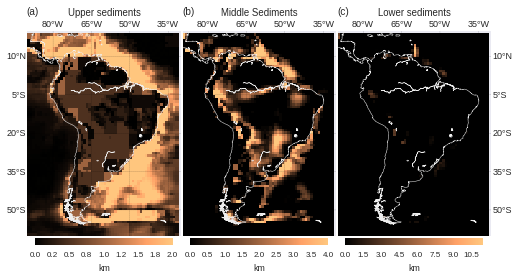

In [20]:
x, y = bm(crust1.lon + 360, crust1.lat) # Transform lat and lon into plot coordinates
fig, axes = plt.subplots(1, 3, figsize=(7, 4))
for i, args in enumerate(zip(layer_names, layers, axes.ravel(), '(a) (b) (c)'.split())):
    layer_name, layer, ax, letter = args
    tmp = bm.pcolormesh(x, y, 0.001*layer.thickness, cmap='copper',  ax=ax)
    cb = plt.colorbar(tmp, ax=ax, pad=0.01, format='%.1f', orientation='horizontal', aspect=20, shrink=0.9)
    cb.set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 15), labels=[0, 0, 1, 0], linewidth=0.2, fontsize=9, ax=ax)
    if i == 0:
        labels = [1, 0, 0, 0]
    elif i == 2:
        labels = [0, 1, 0, 0]
    else:
        labels = [0, 0, 0, 0]
    bm.drawparallels(np.arange(-50, 30, 15), labels=labels, linewidth=0.2, fontsize=9, ax=ax)
    bm.drawcoastlines(color="#eeeeee", linewidth=0.5, ax=ax)    
    ax.set_title(layer_name, y=1.05)
    ax.text(0.0, 1.08, letter, transform=ax.transAxes)
plt.subplots_adjust(left=0.04, bottom=0.0, right=0.96, top=0.95, wspace=0.01, hspace=0.01)
plt.savefig(fig_file.format('sed'), **fig_args)

## South American Moho

First, join the two halfs of the zipped results into a single file using some bash commands.

In [12]:
%%bash
cd results
cat south-america-moho.zip.part* > south-america-moho.zip
cd ..

Load the pickled results dictionary from the combined zip file.

In [13]:
with zipfile.ZipFile('results/south-america-moho.zip') as f:
    results = pickle.load(f.open('south-america-moho.pickle'))

In [14]:
results

{'best_dens': 4,
 'best_ref': 2,
 'best_regul': 0,
 'config': {'initial': array([-60000., -60000., -60000., ..., -60000., -60000., -60000.]),
  'maxit': 6,
  'method': 'newton',
  'tol': 0.2},
 'densities': array([200, 250, 300, 350, 400, 450, 500]),
 'metadata': 'Generated by south-america-moho.ipynb on 11 February 2016 18:13:57 UTC',
 'models_refdens': [<mohoinv.TesseroidRelief at 0x7f1ed89c3450>,
 'models_regul': [<mohoinv.TesseroidRelief at 0x7f1ee2d44590>,
 'reference_levels': array([-40000., -37500., -35000., -32500., -30000., -27500., -25000.,
        -22500., -20000.]),
 'regul_params': array([  1.00000000e-10,   3.41454887e-10,   1.16591440e-09,
          3.98107171e-09,   1.35935639e-08,   4.64158883e-08,
          1.58489319e-07,   5.41169527e-07,   1.84784980e-06,
          6.30957344e-06,   2.15443469e-05,   7.35642254e-05,
          2.51188643e-04,   8.57695899e-04,   2.92864456e-03,
          1.00000000e-02]),
 'scores_refdens': array([[  4.41468316e+08,   3.74774220e+08